In [5]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw=bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

print "Package Versions:"
import sklearn; print "  scikit-learn:", sklearn.__version__
import scipy; print "  scipy:", scipy.__version__
import statsmodels; print "  statsmodels:", statsmodels.__version__

Package Versions:
  scikit-learn: 0.17.1
  scipy: 0.17.0
  statsmodels: 0.6.1


In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/nonparametric/_kernel_base.py:514: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 500 but corresponding boolean dimension is 1
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])


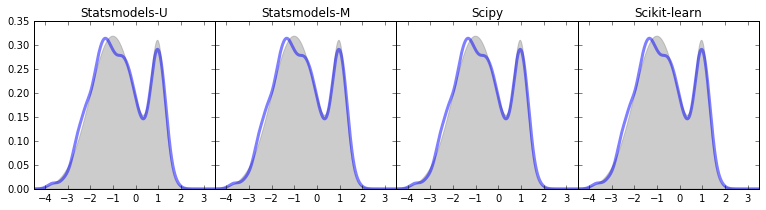

In [8]:
from scipy.stats.distributions import norm

# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(-4.5, 3.5)
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")

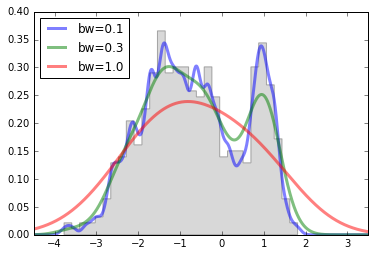

In [9]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.5)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, normed=True)
ax.set_xlim(-4.5, 3.5)
ax.legend(loc='upper left')

In [10]:
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print grid.best_params_

{'bandwidth': 0.19310344827586207}


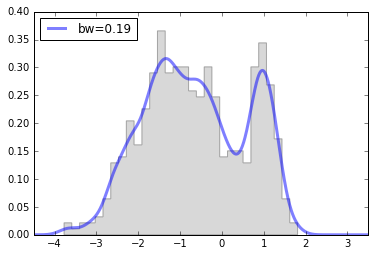

In [11]:
kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))

fig, ax = plt.subplots()
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, normed=True)
ax.legend(loc='upper left')
ax.set_xlim(-4.5, 3.5);

In [6]:
import matplotlib
from collections import defaultdict
from time import time

functions = dict(zip(kde_funcnames, kde_funcs))


def plot_scaling(N=1000, bandwidth=0.1, rtol=0.0,
                 Nreps=3, kwds=None, xgrid=None):
    """
    Plot the time scaling of KDE algorithms.
    Either N, bandwidth, or rtol should be a 1D array.
    """
    if xgrid is None:
        xgrid = np.linspace(-10, 10, 5000)
    if kwds is None:
        kwds=dict()
    for name in functions:
        if name not in kwds:
            kwds[name] = {}
    times = defaultdict(list)
    
    B = np.broadcast(N, bandwidth, rtol)
    assert len(B.shape) == 1
    
    for N_i, bw_i, rtol_i in B:
        x = np.random.normal(size=N_i)
        kwds['Scikit-learn']['rtol'] = rtol_i
        for name, func in functions.items():
            t = 0.0
            for i in range(Nreps):
                t0 = time()
                func(x, xgrid, bw_i, **kwds[name])
                t1 = time()
                t += (t1 - t0)
            times[name].append(t / Nreps)
            
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'axisbg':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    plot_kwds={'linewidth':3, 'alpha':0.5}
    
    if np.size(N) > 1:
        for name in kde_funcnames:
            ax.loglog(N, times[name], label=name, **plot_kwds)
        ax.set_xlabel('Number of points')
    elif np.size(bandwidth) > 1:
        for name in kde_funcnames:
            ax.loglog(bandwidth, times[name], label=name, **plot_kwds)
        ax.set_xlabel('Bandwidth')
    elif np.size(rtol) > 1:
        for name in kde_funcnames:
            ax.loglog(rtol, times[name], label=name, **plot_kwds)
        ax.set_xlabel('Relative Tolerance')
        
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')
    ax.legend(loc=0)
    ax.set_ylabel('time (seconds)')
    ax.set_title('Execution time for KDE '
                 '({0} evaluations)'.format(len(xgrid)))
    
    return times


def plot_scaling_vs_kernel(kernels, N=1000, bandwidth=0.1, rtol=0.0,
                           Nreps=3, kwds=None, xgrid=None):
    """
    Plot the time scaling for Scikit-learn kernels.
    Either N, bandwidth, or rtol should be a 1D array.
    """
    if xgrid is None:
        xgrid = np.linspace(-10, 10, 5000)
    if kwds is None:
        kwds=dict()
    times = defaultdict(list)
    
    B = np.broadcast(N, bandwidth, rtol)
    assert len(B.shape) == 1
    
    for N_i, bw_i, rtol_i in B:
        x = np.random.normal(size=N_i)
        for kernel in kernels:
            kwds['kernel'] = kernel
            kwds['rtol'] = rtol_i
            t = 0.0
            for i in range(Nreps):
                t0 = time()
                kde_sklearn(x, xgrid, bw_i, **kwds)
                t1 = time()
                t += (t1 - t0)
            times[kernel].append(t / Nreps)
            
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'axisbg':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    plot_kwds={'linewidth':3, 'alpha':0.5}
    
    if np.size(N) > 1:
        for kernel in kernels:
            ax.loglog(N, times[kernel], label=kernel, **plot_kwds)
        ax.set_xlabel('Number of points')
    elif np.size(bandwidth) > 1:
        for kernel in kernels:
            ax.loglog(bandwidth, times[kernel], label=kernel, **plot_kwds)
        ax.set_xlabel('Bandwidth')
    elif np.size(rtol) > 1:
        for kernel in kernels:
            ax.loglog(rtol, times[kernel], label=kernel, **plot_kwds)
        ax.set_xlabel('Relative Tolerance')
        
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')
    ax.legend(loc=0)
    ax.set_ylabel('time (seconds)')
    ax.set_title('Execution time for KDE '
                 '({0} evaluations)'.format(len(xgrid)))
    
    return times


def plot_kernels():
    """Visualize the KDE kernels available in Scikit-learn"""
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'axisbg':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')

    X_src = np.zeros((1, 1))
    x_grid = np.linspace(-3, 3, 1000)

    for kernel in ['gaussian', 'tophat', 'epanechnikov',
                   'exponential', 'linear', 'cosine']:
        log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(x_grid[:, None])
        ax.plot(x_grid, np.exp(log_dens), lw=3, alpha=0.5, label=kernel)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-2.9, 2.9)
    ax.legend()

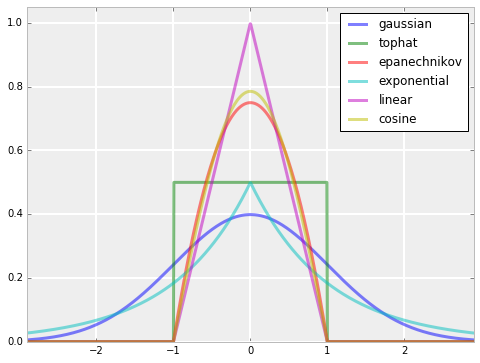

In [12]:
plot_kernels()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/nonparametric/_kernel_base.py:514: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 1
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/nonparametric/_kernel_base.py:514: VisibleDeprecationWarning: boolean index did not match indexed array along dimen

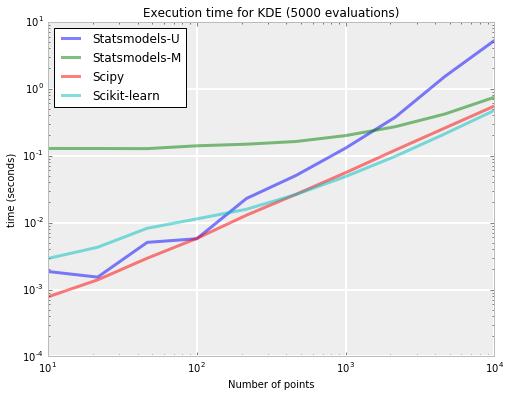

In [13]:
plot_scaling(N=np.logspace(1, 4, 10),
             kwds={'Statsmodels-U':{'fft':False}});


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


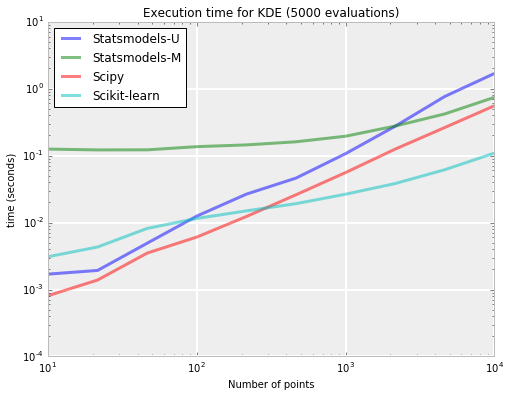

In [15]:
plot_scaling(N=np.logspace(1, 4, 10),
             rtol=1E-4,
             kwds={'Statsmodels-U':{'fft':True}});

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


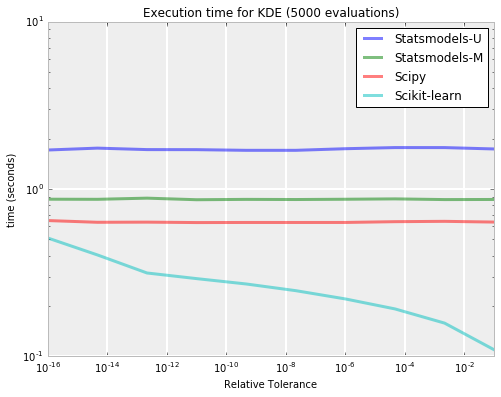

In [16]:
plot_scaling(N=1E4,
             rtol=np.logspace(-16, -1, 10),
             bandwidth=0.2);

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


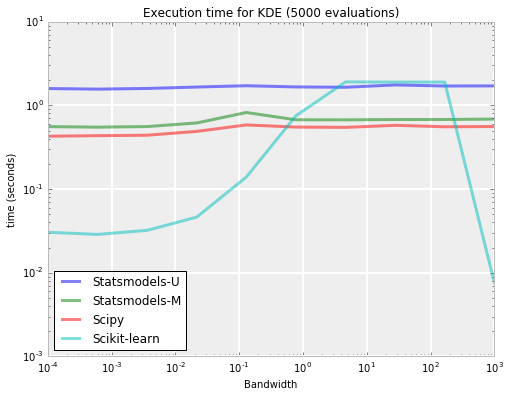

In [17]:
plot_scaling(N=1E4, rtol=1E-4,
             bandwidth=np.logspace(-4, 3, 10));

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


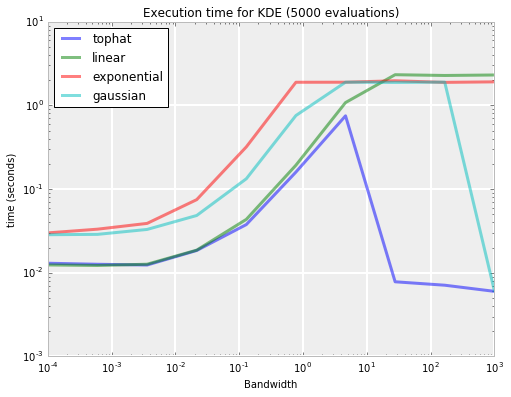

In [18]:
plot_scaling_vs_kernel(kernels=['tophat', 'linear', 'exponential', 'gaussian'],
                       bandwidth=np.logspace(-4, 3, 10),
                       N=1E4, rtol=1E-4);

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


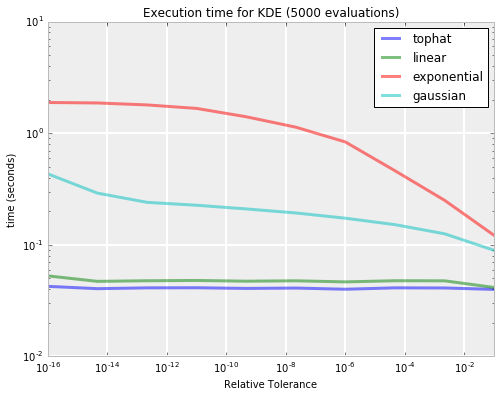

In [19]:
plot_scaling_vs_kernel(kernels=['tophat', 'linear', 'exponential', 'gaussian'],
                       bandwidth=0.15, N=1E4, rtol=np.logspace(-16, -1, 10));

In [20]:
plot_scaling_vs_kernel(kernels=['tophat', 'linear', 'exponential', 'gaussian'],
                       bandwidth=0.15, rtol=1E-4, N=np.logspace(1, 4, 10));<

SyntaxError: invalid syntax (<ipython-input-20-e5d7ad2f63ba>, line 2)